# Quantum Error correction

In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import Aer, transpile, assemble
from qiskit.visualization import plot_histogram
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error

import numpy as np
import matplotlib.pyplot as plt

aer_sim = Aer.get_backend('aer_simulator')

## A. Error Mitigation

In [3]:
def bit_flip_noise(p):
    error_meas  = pauli_error([('X', p), ('I', 1-p)])
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, 'measure')
    
    return noise_model

# This function produce four bell states circuits, i=0,1,2,3 for '00+11','00-11','01+10','01-10' respectively
def make_bell_circuit(i):
    qc = QuantumCircuit(2,2)
    if i == 0 : 
        qc.h(0)
        qc.cx(0,1)
    if i == 1 :
        qc.x(0)
        qc.h(0)
        qc.cx(0,1)
    if i == 2 : 
        qc.h(0)
        qc.cx(0,1)
        qc.x(0)
    if i == 3 : 
        qc.x(0)
        qc.h(0)
        qc.cx(0,1)
        qc.x(0)
    qc.measure([0, 1], [0, 1])
    return qc

In [11]:
C = np.zeros((4, 4), dtype='int')
states = ['00', '01', '10', '11']

for i in range(4):
    qc = QuantumCircuit(2,2)
    if states[i][0]=='1':
        qc.x(1)
    if states[i][1]=='1':
        qc.x(0)  
    qc.measure([0, 1], [0, 1])
    t_qc = transpile(qc, aer_sim)
    qobj = assemble(t_qc)
    result = aer_sim.run(qobj, noise_model=bit_flip_noise(0.1), shots=10000).result()
    counts = result.get_counts()
    print(counts)
    
    counts = counts.int_outcomes()
    
    for j in counts:
        C[j, i] = counts[j]
        
C_inv = np.linalg.inv(C)
C_inv

{'00': 8094, '10': 862, '01': 932, '11': 112}
{'00': 847, '01': 8143, '11': 916, '10': 94}
{'10': 8131, '11': 938, '00': 852, '01': 79}
{'11': 8146, '01': 878, '10': 868, '00': 108}


array([[ 1.26455970e-04, -1.31298741e-05, -1.32558055e-05,
         1.15109548e-06],
       [-1.44980680e-05,  1.25817558e-04,  1.86185791e-06,
        -1.35671639e-05],
       [-1.33915419e-05,  1.44623576e-06,  1.25920631e-04,
        -1.33958527e-05],
       [ 1.43363957e-06, -1.41339192e-05, -1.45266835e-05,
         1.25811921e-04]])

In [12]:
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter

qr = QuantumRegister(2)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')
t_qc = transpile(meas_calibs, aer_sim)
qobj = assemble(t_qc, shots=10000)
result = aer_sim.run(qobj, noise_model=bit_flip_noise(0.1), shots=10000).result()

meas_fitter = CompleteMeasFitter(result, state_labels, circlabel='mcal')
print(meas_fitter.cal_matrix)

[[0.8182 0.0873 0.0896 0.0095]
 [0.0872 0.8154 0.0099 0.0906]
 [0.0865 0.0092 0.8086 0.0874]
 [0.0081 0.0881 0.0919 0.8125]]


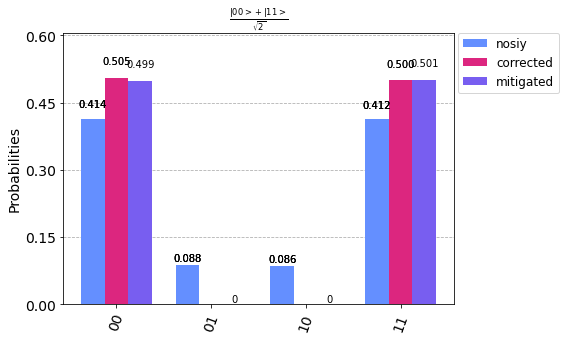

In [13]:
qc=make_bell_circuit(0)

t_qc = transpile(qc, aer_sim)
qobj = assemble(t_qc, shots=10000)
results = aer_sim.run(qobj, noise_model=bit_flip_noise(0.1), shots=10000).result()
noisy_counts = results.get_counts()

state = np.zeros(4)
states = ['00', '01', '10', '11']
corrected_counts = noisy_counts.copy()
for i in range(4):
    state[i] = corrected_counts[states[i]]
state = np.array( ((np.matrix(C_inv)) * np.matrix(state).T).T )[0]
for i in range(4):
    corrected_counts[states[i]] = state[i]
    
mitigated_results = meas_fitter.filter.apply(results)
mitigated_counts  = mitigated_results.get_counts()

plot_histogram([noisy_counts, corrected_counts, mitigated_counts],
               legend=['nosiy', 'corrected', 'mitigated'],
               title='$\\frac{|00>+|11>}{\sqrt{2}}$')

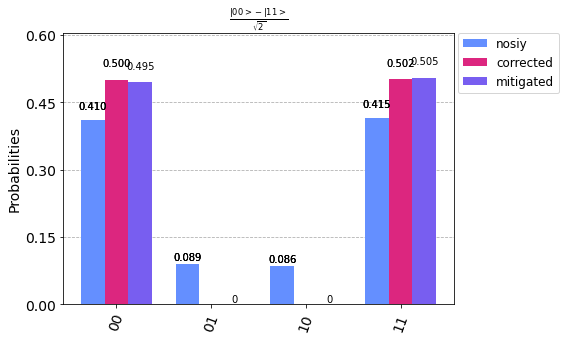

In [14]:
qc = make_bell_circuit(1)

t_qc = transpile(qc, aer_sim)
qobj = assemble(t_qc, shots=10000)
results = aer_sim.run(qobj, noise_model=bit_flip_noise(0.1), shots=10000).result()
noisy_counts = results.get_counts()

state = np.zeros(4)
states = ['00', '01', '10', '11']
corrected_counts = noisy_counts.copy()
for i in range(4):
    state[i] = corrected_counts[states[i]]
state = np.array( ((np.matrix(C_inv)) * np.matrix(state).T).T )[0]
for i in range(4):
    corrected_counts[states[i]] = state[i]
    
mitigated_results = meas_fitter.filter.apply(results)
mitigated_counts  = mitigated_results.get_counts()

plot_histogram([noisy_counts, corrected_counts, mitigated_counts],
               legend=['nosiy', 'corrected', 'mitigated'],
               title='$\\frac{|00>-|11>}{\sqrt{2}}$')

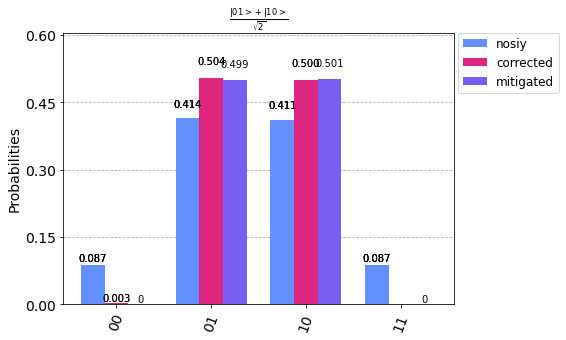

In [15]:
qc = make_bell_circuit(2)

t_qc = transpile(qc, aer_sim)
qobj = assemble(t_qc, shots=10000)
results = aer_sim.run(qobj, noise_model=bit_flip_noise(0.1), shots=10000).result()
noisy_counts = results.get_counts()

state = np.zeros(4)
states = ['00', '01', '10', '11']
corrected_counts = noisy_counts.copy()
for i in range(4):
    state[i] = corrected_counts[states[i]]
state = np.array( ((np.matrix(C_inv)) * np.matrix(state).T).T )[0]
for i in range(4):
    corrected_counts[states[i]] = state[i]
    
mitigated_results = meas_fitter.filter.apply(results)
mitigated_counts  = mitigated_results.get_counts()

plot_histogram([noisy_counts, corrected_counts, mitigated_counts],
               legend=['nosiy', 'corrected', 'mitigated'],
               title='$\\frac{|01>+|10>}{\sqrt{2}}$')

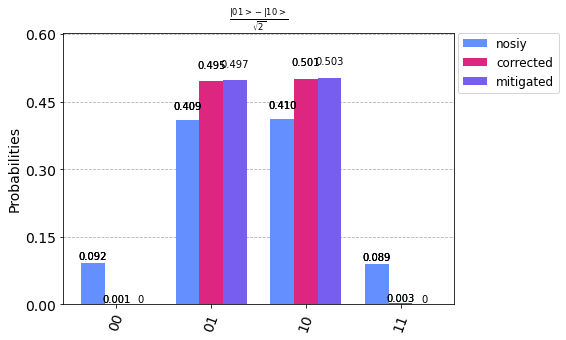

In [9]:
qc = make_bell_circuit(3)

t_qc = transpile(qc, aer_sim)
qobj = assemble(t_qc, shots=10000)
results = aer_sim.run(qobj, noise_model=bit_flip_noise(0.1), shots=10000).result()
noisy_counts = results.get_counts()

state = np.zeros(4)
states = ['00', '01', '10', '11']
corrected_counts = noisy_counts.copy()
for i in range(4):
    state[i] = corrected_counts[states[i]]
state = np.array( ((np.matrix(C_inv)) * np.matrix(state).T).T )[0]
for i in range(4):
    corrected_counts[states[i]] = state[i]
    
mitigated_results = meas_fitter.filter.apply(results)
mitigated_counts  = mitigated_results.get_counts()

plot_histogram([noisy_counts, corrected_counts, mitigated_counts],
               legend=['nosiy', 'corrected', 'mitigated'],
               title='$\\frac{|01>-|10>}{\sqrt{2}}$')

## B. Bit Flip Repetition Code

In [54]:
# A general noise model for following experiments (both bit flip and phase flip)
# Error is on x, z, h, and cx operator
def get_noise(p_meas, p_gate):
    error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
    error_gate1 = depolarizing_error(p_gate, 1)
    error_gate2 = error_gate1.tensor(error_gate1)

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure")
    noise_model.add_all_qubit_quantum_error(error_gate1, ["x"]) 
    noise_model.add_all_qubit_quantum_error(error_gate1, ["z"])
    noise_model.add_all_qubit_quantum_error(error_gate1, ["h"])
    
    noise_model.add_all_qubit_quantum_error(error_gate2, ["cx"]) 
        
    return noise_model

# Select noise model
#noise_model = get_noise(0.01,0.1)
#noise_model = get_noise(0.01,0.05)    # P1
#noise_model = get_noise(0.04,0.05)   # P2
noise_model = get_noise(0.04,0.1)    # P3

In [55]:
from qiskit.ignis.verification.topological_codes import RepetitionCode
from qiskit.ignis.verification.topological_codes import lookuptable_decoding
from qiskit.ignis.verification.topological_codes import GraphDecoder

code = RepetitionCode(3, 1)

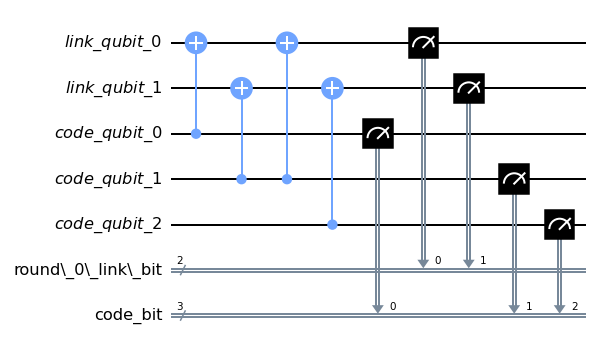

In [56]:
code.circuit['0'].draw('mpl')

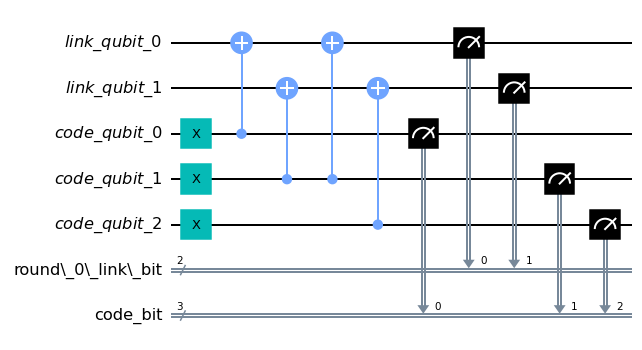

In [57]:
code.circuit['1'].draw('mpl')

In [58]:
def get_raw_results(code, noise_model=None):
    circuits = code.get_circuit_list()
    raw_results = {}
    for log in range(2):
        qobj = assemble(circuits[log])
        job = aer_sim.run(qobj, noise_model=noise_model, shots=1000)
        raw_results[str(log)] = job.result().get_counts(str(log))
    return raw_results

raw_results = get_raw_results(code)
for log in raw_results:
    print('Logical', log, ':', raw_results[log], '\n')

Logical 0 : {'000 00': 1000} 

Logical 1 : {'111 00': 1000} 



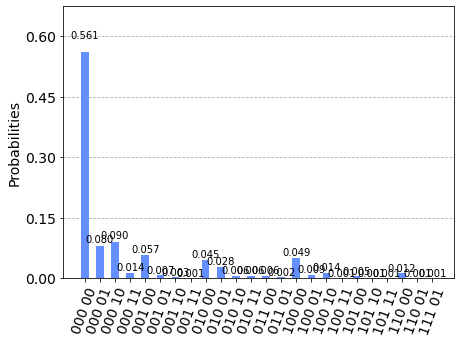

In [59]:
raw_results = get_raw_results(code, noise_model)
plot_histogram(raw_results['0'])

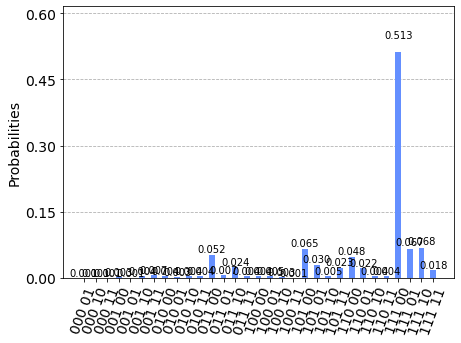

In [60]:
plot_histogram(raw_results['1'])

In [61]:
circuits = code.get_circuit_list()
table_results = {}
for log in range(2):
    qobj = assemble(circuits[log], shots=10000)
    job = aer_sim.run(qobj, noise_model=noise_model)
    table_results[str(log)] = job.result().get_counts(str(log))

#P1 = lookuptable_decoding(table_results, raw_results)
#P2 = lookuptable_decoding(table_results, raw_results)
P3 = lookuptable_decoding(table_results, raw_results)
#print('P =',P1)

In [62]:
print(' error rate   P')
print('--------------------------------------------')
print('(0.01, 0.05)  P1 =', P1)
print('(0.04, 0.05)  P2 =', P2)
print('(0.04, 0.1 )  P2 =', P3)

 error rate   P
--------------------------------------------
(0.01, 0.05)  P1 = {'0': 0.005, '1': 0.004}
(0.04, 0.05)  P2 = {'0': 0.023, '1': 0.022}
(0.04, 0.1 )  P2 = {'0': 0.031, '1': 0.038}


## C. Phase Flip Repetition Code

In [70]:
# Select noise model
#noise_model = get_noise(0.01,0.05)
noise_model = get_noise(0.04,0.05)

In [71]:
cq = QuantumRegister(3, 'code_qubit')
lq = QuantumRegister(2, 'link_qubit')
sb = ClassicalRegister(2, 'syndrome_bit')
cb = ClassicalRegister(3, 'code_bit')

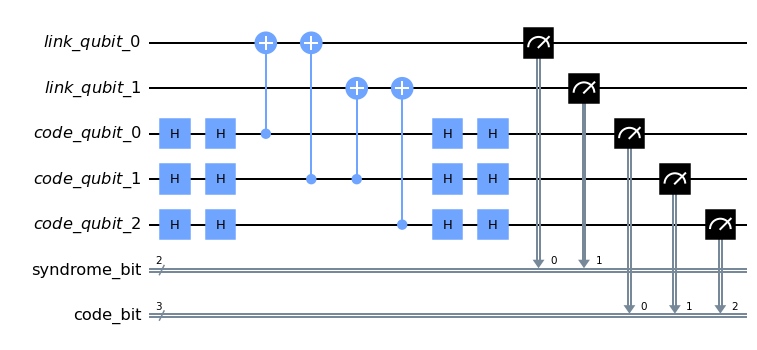

In [72]:
# 0
qc0 = QuantumCircuit(lq, cq, sb, cb, name='0')

qc0.h(cq)
qc0.h(cq)
for i in range(2):
    qc0.cx(cq[0+i], lq[i])
    qc0.cx(cq[1+i], lq[i])
qc0.barrier()
qc0.h(cq)
qc0.h(cq)

qc0.barrier()
qc0.measure(lq, sb)
qc0.measure(cq, cb)
qc0.draw('mpl', plot_barriers=False)

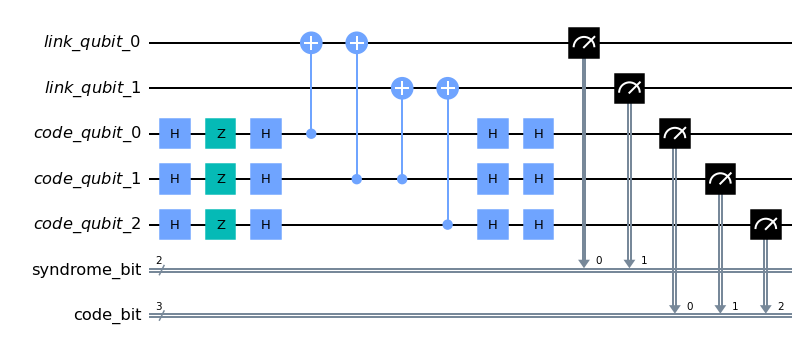

In [73]:
# 1
qc1 = QuantumCircuit(lq, cq, sb, cb, name='1')

qc1.h(cq)
qc1.z(cq)
qc1.h(cq)
for i in range(2):
    qc1.cx(cq[0+i], lq[i])
    qc1.cx(cq[1+i], lq[i])
qc1.barrier()
qc1.h(cq)
qc1.h(cq)

qc1.barrier()
qc1.measure(lq, sb)
qc1.measure(cq, cb)
qc1.draw('mpl', plot_barriers=False)

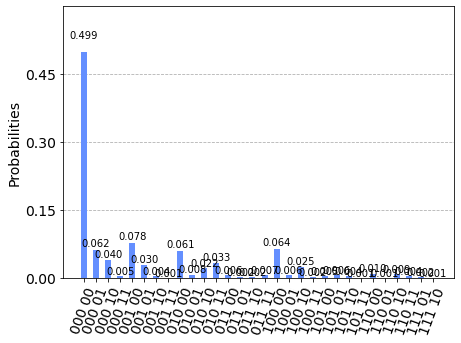

In [74]:
phase_circuits = [qc0, qc1]
raw_results = {}
for log in range(2):
    qobj = assemble(phase_circuits[log])
    job = aer_sim.run(qobj, noise_model=noise_model, shots=1000)
    raw_results[str(log)] = job.result().get_counts(str(log))
    
plot_histogram(raw_results['0'])

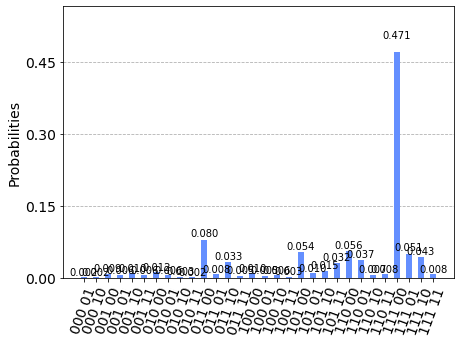

In [75]:
plot_histogram(raw_results['1'])

In [76]:
phase_circuits = [qc0, qc1]
table_results = {}
for log in range(2):
    qobj = assemble(phase_circuits[log], shots=10000)
    job = aer_sim.run(qobj, noise_model=noise_model)
    table_results[str(log)] = job.result().get_counts(str(log))

#P1 = lookuptable_decoding(table_results, raw_results)
P2 = lookuptable_decoding(table_results, raw_results)

In [77]:
print(' error rate   P')
print('--------------------------------------------')
print('(0.01, 0.05)  P1 =', P1)
print('(0.04, 0.05)  P2 =', P2)

 error rate   P
--------------------------------------------
(0.01, 0.05)  P1 = {'0': 0.055, '1': 0.063}
(0.04, 0.05)  P2 = {'0': 0.063, '1': 0.063}


## D. Shor's Code (9,1)

In [88]:
# Select noise model
#noise_model = get_noise(0.01,0.05)   # P1
noise_model = get_noise(0.04,0.05)    # P2

In [89]:
cq = QuantumRegister(1, 'code_qubit')
lq = QuantumRegister(8, 'link_qubit')
sb = ClassicalRegister(8, 'syndrome_bit')
cb = ClassicalRegister(1, 'code_bit')

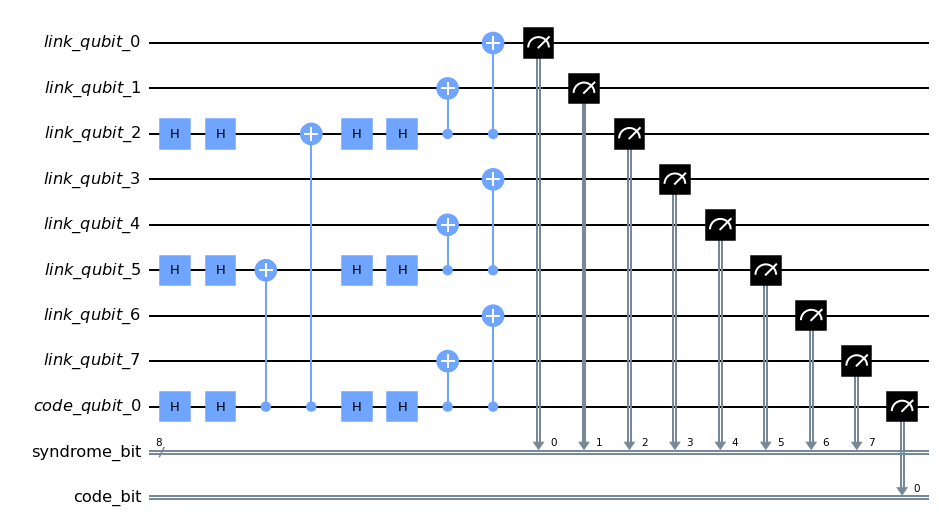

In [90]:
# 0
qc0 = QuantumCircuit(lq, cq, sb, cb, name='0')

# phase flit correction
for i in range(2):
    qc0.h(cq)
    qc0.h(lq[5])
    qc0.h(lq[2])
qc0.cx(cq, lq[5])
qc0.cx(cq, lq[2])
qc0.barrier()

# bit flip correction
for i in range(2):
    qc0.h(cq)
    qc0.h(lq[5])
    qc0.h(lq[2])
for i in range(2):
    qc0.cx(cq, lq[7-i])
    qc0.cx(lq[5], lq[4-i])
    qc0.cx(lq[2], lq[1-i])
qc0.barrier()


qc0.barrier()
qc0.measure(lq, sb)
qc0.measure(cq, cb)
qc0.draw('mpl', plot_barriers=False)

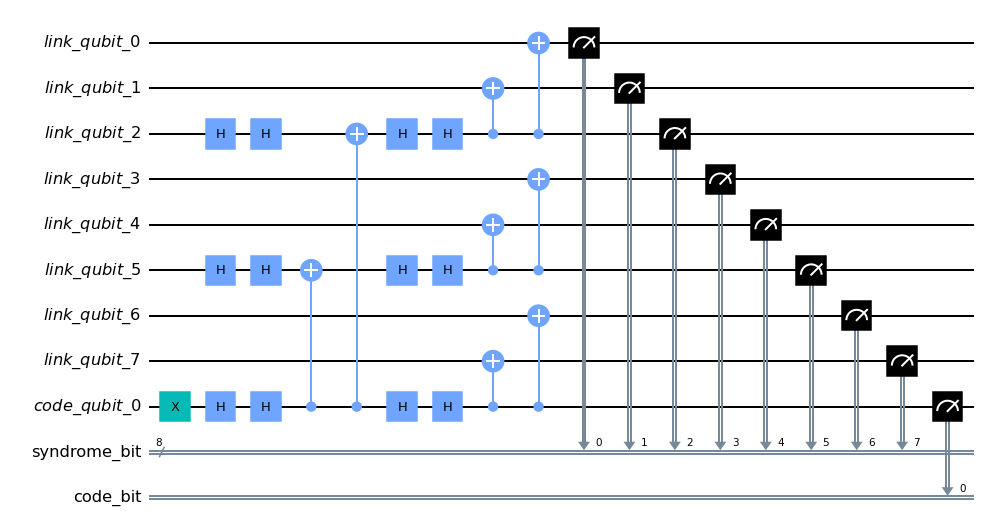

In [91]:
# 1
qc1 = QuantumCircuit(lq, cq, sb, cb, name='1')
qc1.x(cq)
qc1.barrier()

# phase flit correction
for i in range(2):
    qc1.h(cq)
    qc1.h(lq[5])
    qc1.h(lq[2])
qc1.cx(cq, lq[5])
qc1.cx(cq, lq[2])
qc1.barrier()

# bit flip correction
for i in range(2):
    qc1.h(cq)
    qc1.h(lq[5])
    qc1.h(lq[2])
for i in range(2):
    qc1.cx(cq, lq[7-i])
    qc1.cx(lq[5], lq[4-i])
    qc1.cx(lq[2], lq[1-i])
qc1.barrier()


qc1.barrier()
qc1.measure(lq, sb)
qc1.measure(cq, cb)
qc1.draw('mpl', plot_barriers=False)

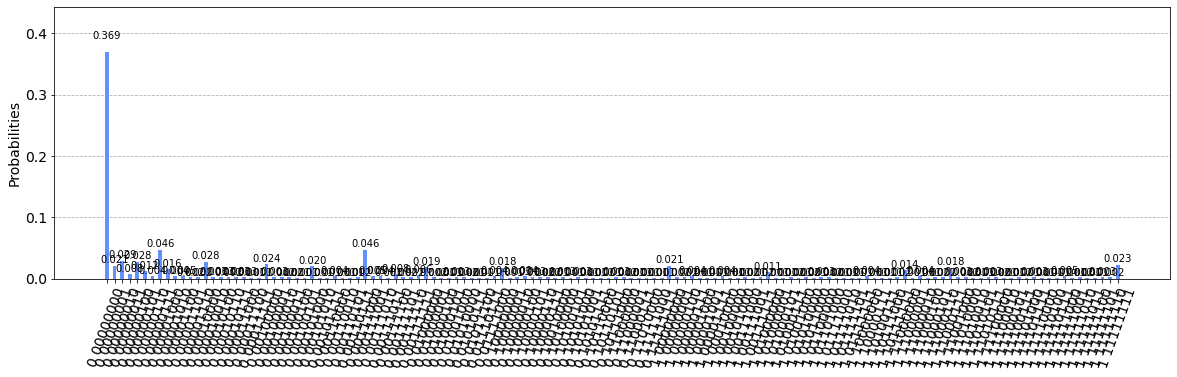

In [92]:
phase_circuits = [qc0, qc1]
raw_results = {}
for log in range(2):
    qobj = assemble(phase_circuits[log])
    job = aer_sim.run(qobj, noise_model=noise_model, shots=1000)
    raw_results[str(log)] = job.result().get_counts(str(log))
    
plot_histogram(raw_results['0'],figsize=(20, 5))

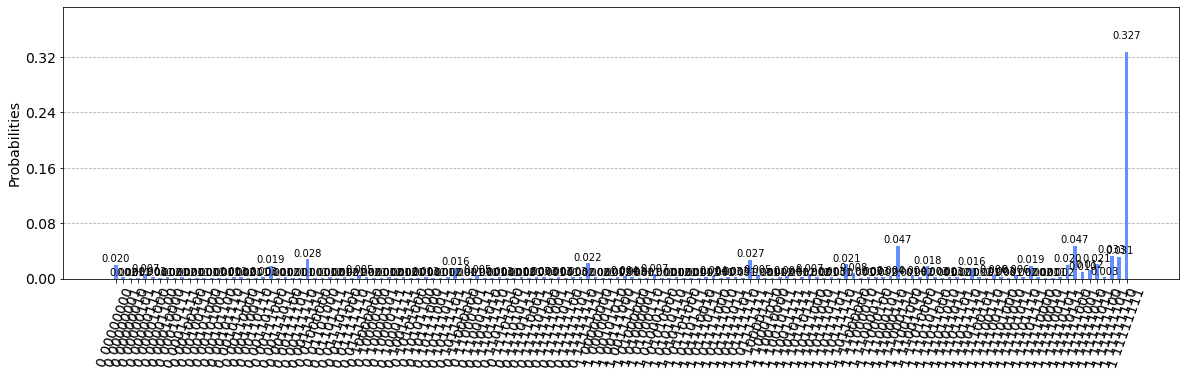

In [93]:
plot_histogram(raw_results['1'],figsize=(20, 5))

#### simulation

In [96]:
phase_circuits = [qc0, qc1]
table_results = {}
for log in range(2):
    qobj = assemble(phase_circuits[log], shots=10000)
    job = aer_sim.run(qobj, noise_model=noise_model)
    table_results[str(log)] = job.result().get_counts(str(log))

#P1 = lookuptable_decoding(table_results, raw_results)
P2 = lookuptable_decoding(table_results, raw_results)

In [97]:
print(' error rate   P')
print('--------------------------------------------')
print('(0.01, 0.05)  P1 =', P1)
print('(0.04, 0.05)  P2 =', P2)

 error rate   P
--------------------------------------------
(0.01, 0.05)  P1 = {'0': 0.11, '1': 0.124}
(0.04, 0.05)  P2 = {'0': 0.113, '1': 0.112}


#### ibmq_guadalupe (16 qubits)

In [98]:
from qiskit import IBMQ
from qiskit.tools.monitor import job_monitor
IBMQ.load_account()
IBMQ.providers()

[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>,
 <AccountProvider for IBMQ(hub='ibm-q-hub-ntu', group='ntu-internal', project='default')>]

In [99]:
provider = IBMQ.get_provider(project='default')
backend = provider.get_backend('ibmq_guadalupe')

<ipython-input-100-ceb57b59187a>:5: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(qobj, shots=1000)


Job Status: job has successfully run
Job Status: job has successfully run


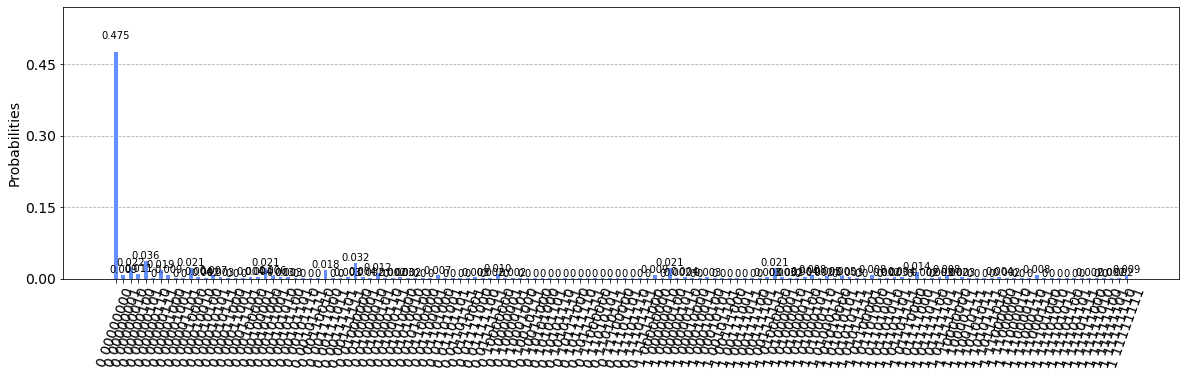

In [100]:
phase_circuits = [qc0, qc1]
raw_results = {}
for log in range(2):
    qobj = assemble(transpile(phase_circuits[log], backend=backend))
    job = backend.run(qobj, shots=1000)
    job_monitor(job)
    raw_results[str(log)] = job.result().get_counts(str(log))
    
plot_histogram(raw_results['0'],figsize=(20, 5))

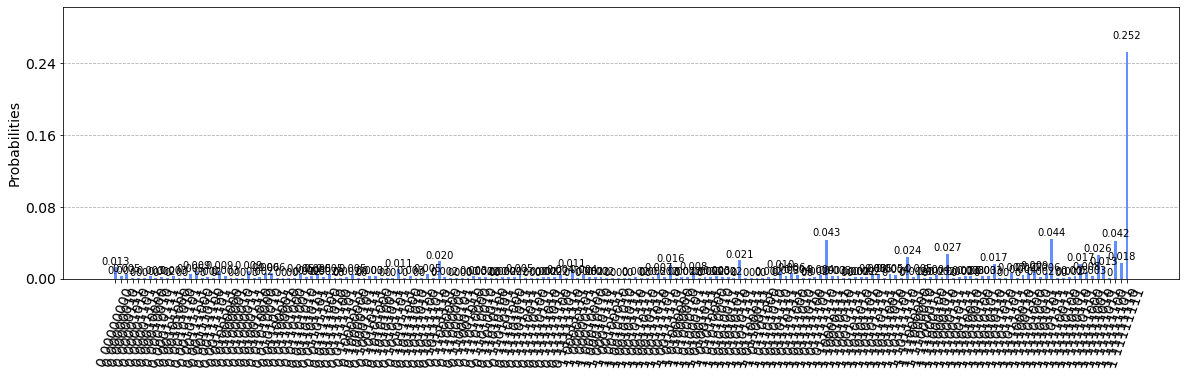

In [101]:
plot_histogram(raw_results['1'],figsize=(20, 5))